# Data Modeling Notebook

In the last notebook it became clear, that there is relationship between the market price and the residual load, which is the portion of consumed energy not generated by renewable sources. Especially brown and black coal are connected to the price

### Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.models import Model
from keras.models import load_model, save_model
from keras.layers import Dense, LSTM, Input, Dropout
from keras.losses import MeanSquaredError


In [2]:
sns.set_style(style='darkgrid')

### Data Loading

In [3]:
# import the dataframes
df_RConE = pd.read_pickle('../Data Cleansed/Real_consumed_energy.pkl')
df_MP = pd.read_pickle('../Data Cleansed/Market_price.pkl')
# set Timestamp as index and resample Marketprices to 15 minutes.
df_RConE.set_index('Timestamp', drop=True, inplace=True)
df_MP.set_index('Timestamp', drop=True, inplace=True)

In [4]:
df_Total_RConE = df_RConE
df_Total_RConE.rename(columns={'Total (Grid Load) [MWh]':'Total', 'Residuallast [MWh]':'Residual Load', 'Pumpspeicher [MWh]':'Pumped Storage'}, inplace=True)
df_Total_RConE['Renewables'] = df_Total_RConE['Total'] - df_Total_RConE['Residual Load'] - df_Total_RConE['Pumped Storage']

df_Total_RConE['year'] = df_Total_RConE.index
df_Total_RConE['month'] = df_Total_RConE['year'].dt.month
df_Total_RConE['day'] = df_Total_RConE['year'].dt.day
df_Total_RConE['day_of_year'] = df_Total_RConE['year'].dt.dayofyear
df_Total_RConE['year'] = df_Total_RConE['year'].dt.year

In [5]:
# no need to consider the market prices outside of Germany
MP_DE = df_MP[['Germany/Luxemburg [€/MWh]']]
MP_DE.rename(columns={'Germany/Luxemburg [€/MWh]': 'DE'}, inplace=True)
#resample MP_DE
#MP_DE = MP_DE.resample('15 Min').ffill() #just fills the NAN with the last known value
MP_DE =MP_DE.resample('15 Min').interpolate(method='linear') # alternative use would be method='time'

C:\Users\sager\AppData\Local\Temp\ipykernel_54472\3587077433.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MP_DE.rename(columns={'Germany/Luxemburg [€/MWh]': 'DE'}, inplace=True)


In [6]:
# del unncessary Dataframes to conserve memory
del df_MP
del df_RConE

Correlations between market price and Consumed Energy

In [7]:
MP_RCON = MP_DE.join(df_Total_RConE, how='inner', validate='one_to_one') # outer join on index aka Timestamp

In [8]:
del df_Total_RConE

In [9]:
MP_RCON.drop(columns=['year', 'month', 'day', 'day_of_year', 'Renewables', 'Pumped Storage', 'Total'], inplace=True)

### Preprocessing the data
1. Scale the data
2. Split the data into training and validation sets

In [10]:
Data_Mean = MP_RCON.mean()

In [11]:
Data_Std = MP_RCON.std()

In [12]:
Data_Scaled = (MP_RCON - Data_Mean) / Data_Std

In [13]:
print('Market prices max:', Data_Scaled['DE'].max())
print('Market prices min:', Data_Scaled['DE'].min())
print('\n')
print('Residual load max:', Data_Scaled['Residual Load'].max())
print('Residual load min:', Data_Scaled['Residual Load'].min())

Market prices max: 6.246091629423516
Market prices min: -5.508796063010782


Residual load max: 2.7741112456497605
Residual load min: -3.0565987339682277


Values are larger / smaller than unity. So I need to scale it in a different way.

In [14]:
Data_max_abs = MP_RCON.abs().max()

In [15]:
Data_Scaled = MP_RCON / Data_max_abs

In [16]:
print('Market prices max:', Data_Scaled['DE'].max())
print('Market prices min:', Data_Scaled['DE'].min())
print('\n')
print('Residual load max:', Data_Scaled['Residual Load'].max())
print('Residual load min:', Data_Scaled['Residual Load'].min())

Market prices max: 1.0
Market prices min: -0.574052812858783


Residual load max: 1.0
Residual load min: -0.08652674908642874


We have 105105 rows, most of them are 15 minutes apart. 
So for an hour we have 4 rows, for a day 96 row, for a week 672 rows. Days and weeks would be great batch sizes for the LSTM. 
For a stateful LSTM I need to make sure, that there is no left over in the training set (modulo = 0)

In [17]:
Data_Scaled.shape

(105105, 2)

In [18]:
# I define a function to find the right size for the train and test data.
# The right size is defined by a modulo of 0.
def get_train_length(data, window, test_percent):
    length = len(data)
    length_values=[]
    split_values=[]
    for i in range(length, int(length * (1-test_percent)), -1):
        if i % window == 0:
            length_values.append(i)
            split_values.append(i/length)
    #print (list(zip(length_values, split_values)))
    return list(zip(length_values, split_values))

**Note:** The *Keras timestep* means basically the window aka sample length of each sample batch. 

In [19]:
window = 96 # 4 samples * 24 hours = 96,

In [20]:
get_train_length(Data_Scaled, window, 0.15)

[(105024, 0.999229342086485),
 (104928, 0.9983159697445412),
 (104832, 0.9974025974025974),
 (104736, 0.9964892250606536),
 (104640, 0.9955758527187099),
 (104544, 0.9946624803767661),
 (104448, 0.9937491080348223),
 (104352, 0.9928357356928785),
 (104256, 0.9919223633509348),
 (104160, 0.991008991008991),
 (104064, 0.9900956186670472),
 (103968, 0.9891822463251034),
 (103872, 0.9882688739831597),
 (103776, 0.9873555016412159),
 (103680, 0.9864421292992721),
 (103584, 0.9855287569573283),
 (103488, 0.9846153846153847),
 (103392, 0.9837020122734409),
 (103296, 0.9827886399314971),
 (103200, 0.9818752675895533),
 (103104, 0.9809618952476096),
 (103008, 0.9800485229056658),
 (102912, 0.979135150563722),
 (102816, 0.9782217782217782),
 (102720, 0.9773084058798345),
 (102624, 0.9763950335378907),
 (102528, 0.9754816611959469),
 (102432, 0.9745682888540032),
 (102336, 0.9736549165120594),
 (102240, 0.9727415441701156),
 (102144, 0.9718281718281718),
 (102048, 0.970914799486228),
 (101952, 0.

In [21]:
Data_Scaled_train = Data_Scaled.iloc[0:89376, :].values
Data_Scaled_val = Data_Scaled.iloc[89376:, :].values

In [22]:
print('Shape of Data_Scaled_train', Data_Scaled_train.shape, '\nShape of Data_Scaled_val', Data_Scaled_val.shape)

Shape of Data_Scaled_train (89376, 2) 
Shape of Data_Scaled_val (15729, 2)


Time to split the data into Y and X

In [23]:
def createXY(dataset, n_past): #n_past is the number of past steps we want to look at aka Timesteps aka window
    dataX = []
    dataY = []

    for i in range(n_past, len(dataset)):
        dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]]) # rem. both columns 'DE' and 'Residual Load' are included, as the future value of 'DE' als dependendent on its past values
        dataY.append(dataset[i, 0])
    return np.array(dataX), np.array(dataY)

In [24]:
X_train, y_train = createXY(Data_Scaled_train, window)
X_val, y_val = createXY(Data_Scaled_val, window)

In [25]:
#Check shape
print('Shape of X_train', X_train.shape, '\nShape of y_train', y_train.shape, '\nShape of X_val', X_val.shape, '\nShape of y_val', y_val.shape)

Shape of X_train (89280, 96, 2) 
Shape of y_train (89280,) 
Shape of X_val (15633, 96, 2) 
Shape of y_val (15633,)


In [26]:
X_val.shape[0]%(2*window)

81

So, the code says, I have 81 rows left, probably in X_val and Y_val.
If so, then I will need to drop them.

In [27]:
X_val_altered = X_val[:-81]
y_val_altered = y_val[:-81]

In [28]:
X_val_altered.shape[0]%(2*window)

0

In [29]:
X_val_altered.shape

(15552, 96, 2)

### Build the model

In [30]:
#Zum HERUMPROBIEREN
model = Sequential()
model.add(LSTM(12, activation='tanh', return_sequences=True, recurrent_activation='sigmoid', stateful=False,))# batch_input_shape=(2*window, X_train.shape[1], X_train.shape[2])))
model.add(LSTM(12, activation='tanh', return_sequences=False, recurrent_activation='sigmoid', stateful=False))
model.add(Dense(1, activation='tanh'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [66]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [67]:
model.fit(X_train, y_train, epochs=10, batch_size=2*window, validation_data=(X_val_altered, y_val_altered))

Epoch 1/10
465/465 [==============================] - 7s 11ms/step - loss: 0.0034 - accuracy: 3.5842e-04 - val_loss: 3.6051e-04 - val_accuracy: 7.0730e-04
Epoch 2/10
465/465 [==============================] - 5s 10ms/step - loss: 4.3159e-04 - accuracy: 3.5842e-04 - val_loss: 1.9731e-04 - val_accuracy: 7.0730e-04
Epoch 3/10
465/465 [==============================] - 5s 10ms/step - loss: 2.1730e-04 - accuracy: 3.5842e-04 - val_loss: 1.3472e-04 - val_accuracy: 7.0730e-04
Epoch 4/10
465/465 [==============================] - 5s 11ms/step - loss: 1.4369e-04 - accuracy: 3.5842e-04 - val_loss: 9.0190e-05 - val_accuracy: 7.0730e-04
Epoch 5/10
465/465 [==============================] - 5s 10ms/step - loss: 1.0691e-04 - accuracy: 3.5842e-04 - val_loss: 6.4687e-05 - val_accuracy: 7.0730e-04
Epoch 6/10
465/465 [==============================] - 5s 10ms/step - loss: 8.6064e-05 - accuracy: 3.5842e-04 - val_loss: 5.2077e-05 - val_accuracy: 7.0730e-04
Epoch 7/10
465/465 [==============================

In [68]:
prediction = model.predict(X_val_altered)


486/486 [==============================] - 3s 5ms/step


In [69]:
prediction.shape

(15552, 1)

In [70]:
# LSTM stateful model with MSE loss function

#input
#inputs = Input(shape=(Timesteps,1), batch_size=batch_size)
#inputs = Input(batch_shape=(876,Timesteps,1))
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]), batch_size=2*window)

# LSTM layer; recurrent_activation='sigmoid' is default setting
lstm1 = LSTM(12, 
             activation='tanh',
             recurrent_activation='sigmoid', 
             return_sequences=True, 
             stateful=True,
             #dropout=0.5
             )(inputs)



# LSTM layer; recurrent_activation='sigmoid' is default setting
lstm2 = LSTM(12,
             activation='tanh',
             recurrent_activation='sigmoid',
             return_sequences=False,
             stateful=True) (lstm1)

#output
output = Dense(1, activation='tanh')(lstm2)

model = Model(inputs=inputs, outputs=output)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [71]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(192, 96, 2)]            0         
                                                                 
 lstm_18 (LSTM)              (192, 96, 12)             720       
                                                                 
 lstm_19 (LSTM)              (192, 12)                 1200      
                                                                 
 dense_7 (Dense)             (192, 1)                  13        
                                                                 
Total params: 1,933
Trainable params: 1,933
Non-trainable params: 0
_________________________________________________________________


Let's retry

In [72]:
history = model.fit(X_train, y_train, epochs=10, batch_size=2*window, validation_data=(X_val_altered, y_val_altered))

Epoch 1/10
465/465 [==============================] - 7s 12ms/step - loss: 0.0028 - accuracy: 3.5842e-04 - val_loss: 2.5770e-04 - val_accuracy: 7.0730e-04
Epoch 2/10
465/465 [==============================] - 5s 11ms/step - loss: 2.9201e-04 - accuracy: 3.5842e-04 - val_loss: 1.3523e-04 - val_accuracy: 7.0730e-04
Epoch 3/10
465/465 [==============================] - 5s 11ms/step - loss: 1.6118e-04 - accuracy: 3.5842e-04 - val_loss: 9.0548e-05 - val_accuracy: 7.0730e-04
Epoch 4/10
465/465 [==============================] - 5s 11ms/step - loss: 1.0744e-04 - accuracy: 3.5842e-04 - val_loss: 9.1524e-05 - val_accuracy: 7.0730e-04
Epoch 5/10
465/465 [==============================] - 5s 11ms/step - loss: 7.8376e-05 - accuracy: 3.5842e-04 - val_loss: 4.8634e-05 - val_accuracy: 7.0730e-04
Epoch 6/10
465/465 [==============================] - 5s 11ms/step - loss: 6.2008e-05 - accuracy: 3.5842e-04 - val_loss: 4.0100e-05 - val_accuracy: 7.0730e-04
Epoch 7/10
465/465 [==============================

In [74]:
prediction = model.predict(X_val_altered, batch_size=2*window)

81/81 [==============================] - 1s 7ms/step


In [75]:
prediction.shape

(15552, 1)

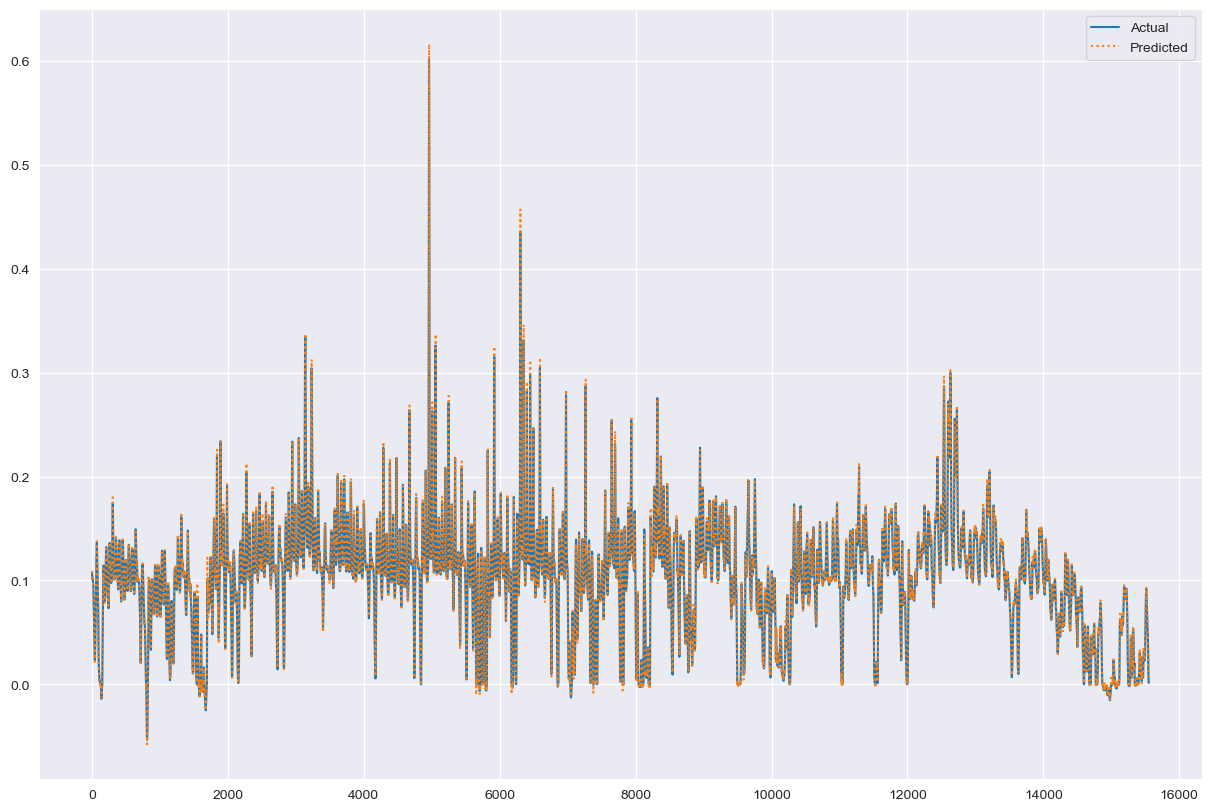

In [83]:
plt.figure(figsize=(15,10))
plt.plot(y_val_altered, label='Actual')
plt.plot(prediction, label='Predicted', linestyle='dotted')
plt.legend()
plt.show()

In [87]:
Data_max_abs['DE']

871.0

Denormalize the values

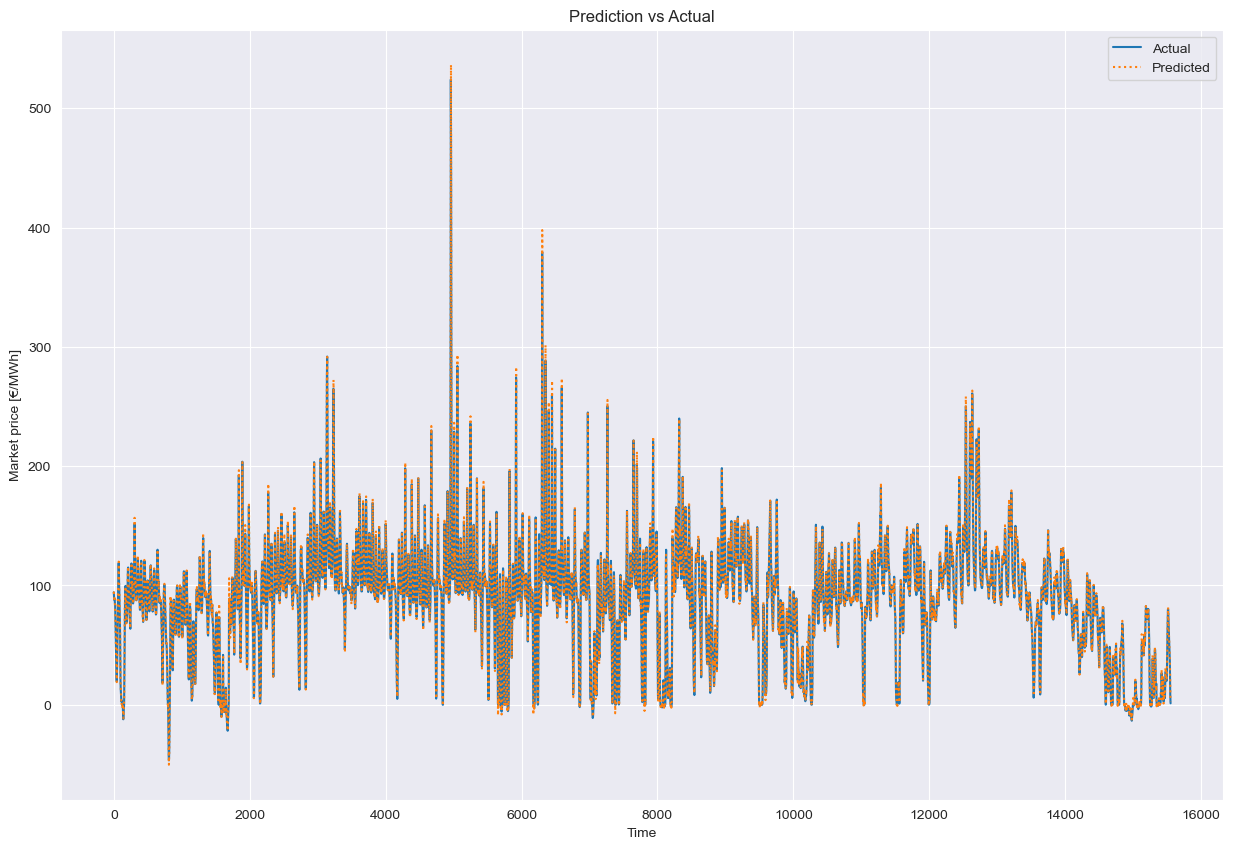

In [89]:
plt.figure(figsize=(15,10))
plt.plot(y_val_altered*Data_max_abs['DE'], label='Actual')
plt.plot(prediction*Data_max_abs['DE'], label='Predicted', linestyle='dotted')
plt.xlabel('Time')
plt.ylabel('Market price [€/MWh]')
plt.title('Prediction vs Actual')
plt.legend()
plt.show()

In [91]:
save_model(model, 'model.h5')

Had a break here

In [30]:
model = load_model('model.h5')

81/81 [==============================] - 1s 7ms/step


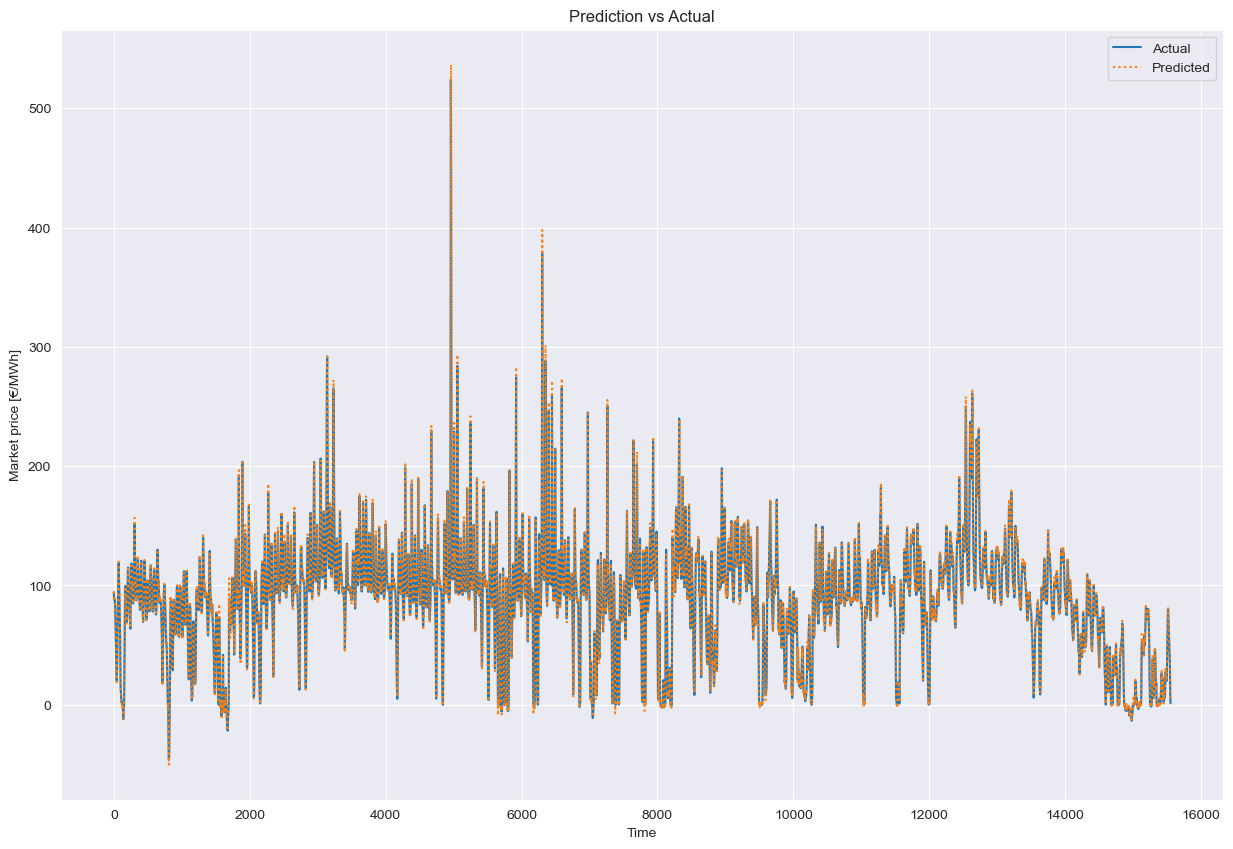

In [31]:
prediction = model.predict(X_val_altered, batch_size=2*window)
plt.figure(figsize=(15,10))
plt.plot(y_val_altered*Data_max_abs['DE'], label='Actual')
plt.plot(prediction*Data_max_abs['DE'], label='Predicted', linestyle='dotted')
plt.xlabel('Time')
plt.ylabel('Market price [€/MWh]')
plt.title('Prediction vs Actual')
plt.legend()
plt.show()

In [32]:
#let's take a closer look at the prediction

print('max value from prediction:', Data_max_abs['DE']*prediction.max())
print('max value from actual:', Data_max_abs['DE']*y_val_altered.max())
print('\n')
print('min value from prediction:', Data_max_abs['DE']*prediction.min())
print('min value from actual:', Data_max_abs['DE']*y_val_altered.min())

max value from prediction: 536.5876531600952
max value from actual: 524.27


min value from prediction: -50.24938699603081
min value from actual: -46.61


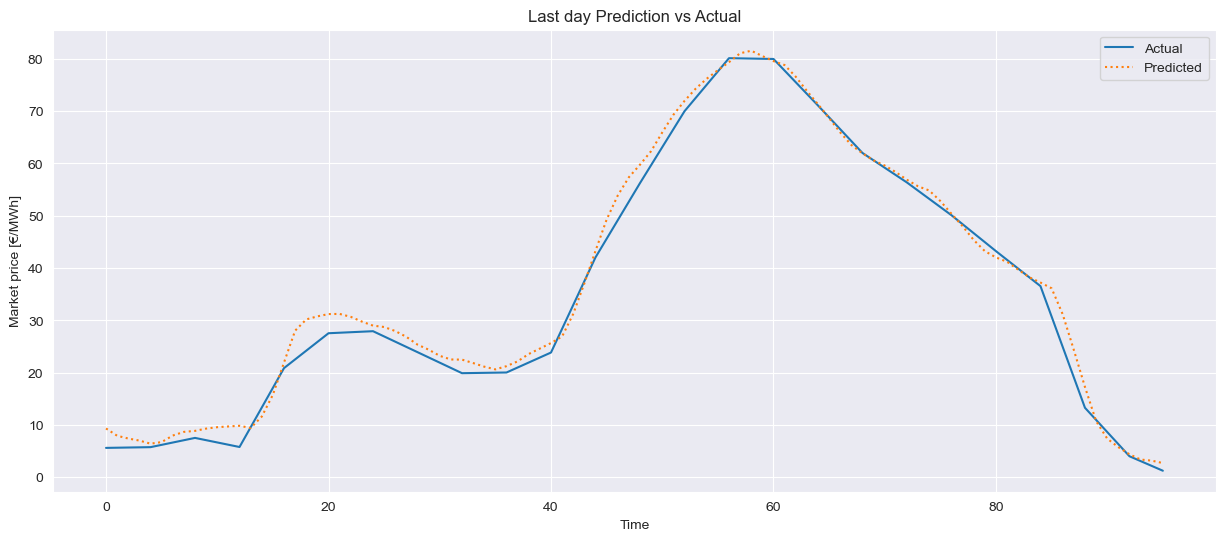

In [58]:
plt.figure(figsize=(15,6))
plt.plot(y_val_altered[-96:]*Data_max_abs['DE'], label='Actual')
plt.plot(prediction[-96:]*Data_max_abs['DE'], label='Predicted', linestyle='dotted')
plt.xlabel('Time')
plt.ylabel('Market price [€/MWh]')
plt.title('Last day Prediction vs Actual')

plt.legend()
plt.show()

In [ ]:
print('location of max value from prediction:', prediction.argmax())
print('location of max value from actual:', y_val_altered.argmax())
print('\n')
print('location of min value from prediction:', prediction.argmin())
print('location of min value from actual:', y_val_altered.argmin())

location of max value from prediction: 4962
location of max value from actual: 4960


location of min value from prediction: 811
location of min value from actual: 812


In [49]:
# want to see the entire day, so let's find out, where themax value is.
print(4960/96)
print(812/96)

51.666666666666664
8.458333333333334


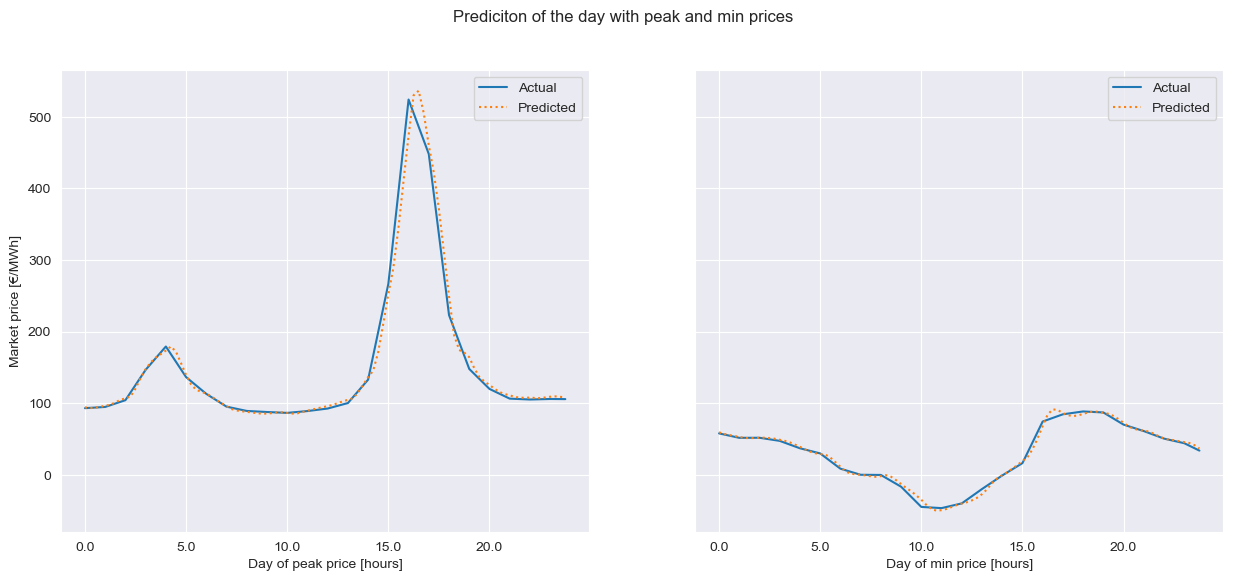

In [53]:
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(15,6), sharey=True)
fig.suptitle('Prediciton of the day with peak and min prices')

ax1.plot(y_val_altered[51*96:52*96]*Data_max_abs['DE'], label='Actual')
ax1.plot(prediction[51*96:52*96]*Data_max_abs['DE'], label='Predicted', linestyle='dotted')
ax1.set_xlabel('Day of peak price [hours]')
ax1.set_ylabel('Market price [€/MWh]')
ax1.xaxis.set_major_formatter(lambda x, pos:"%.0f" % (x/4))
ax1.legend()

ax2.plot(y_val_altered[8*96:9*96]*Data_max_abs['DE'], label='Actual')
ax2.plot(prediction[8*96:9*96]*Data_max_abs['DE'], label='Predicted', linestyle='dotted')
ax2.set_xlabel('Day of min price [hours]')
ax2.xaxis.set_major_formatter(lambda x, pos:"%.0f" % (x/4))
ax2.legend()




plt.show()

### Conclusion

The model works surprisingly well. It is predicting the course of gross market prices one day ahead. 